<font face = "Times New Roman" size = "3" color = "black">
<center>
<h3></h3>
<img src = "https://proleon.com.mx/wp-content/uploads/2022/10/01_TM_ESPECIAL_INNOVACION_EDUCATIVA_UNIVERSIDADES_TEC_DE_MONTERREY.png" width = "250">
<h3><b>Campus Estado de México</h3>
<h3>Diseño de redes neuronales y aprendizaje profundo</b><br>MA2004B.201 2024-13<br><br><b>
Situación problema: Clasificación de prendas de vestir<br><br>Autores</b><br>Santiago Jiménez Pasillas - A01749970<br>Guillermo Ian Barbosa Martínez - A01747926<br><br><b>Profesor</b><br>Andrea Torres Calderón</h3>


# **Introducción**

Este proyecto tiene como objetivo clasificar imágenes de la base de datos Fashion MNIST utilizando redes neuronales convolucionales (CNNs). Se diseñaron dos arquitecturas principales para explorar diferentes configuraciones y técnicas de optimización:


1.   Capas Convolucionales y de Pooling: Ambas redes emplean filtros 3x3 con activación ReLU, normalización de batches y Dropout para prevenir sobreajuste. La red 1 utiliza MaxPooling, mientras que la red 2 emplea AvgPooling.
2.   Capas Completamente Conectadas: Transforman las salidas convolucionales en vectores y combinan activaciones como ReLU y LeakyReLU en la red 1, mientras que la red 2 usa solo ReLU. Ambas finalizan con una capa de salida de 10 clases.

Adicionalmente, se implementaron Data Augmentation para aumentar la diversidad de datos y Transfer Learning para evaluar si un modelo preentrenado mejora el rendimiento. El análisis busca comparar configuraciones y estrategias para identificar su impacto en la precisión y generalización del modelo.



# **Dependencias**

In [ ]:
!pip install torchinfo

In [ ]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import ConcatDataset, DataLoader, random_split
from torch import nn
from torch import optim
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import random
import plotly.express as px
from torchinfo import summary
from tqdm.auto import tqdm
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# **Carga de datos**

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))]
)

augmentations = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))]
)

In [ ]:
# Original data
train_data  = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

100%|██████████| 26.4M/26.4M [00:02<00:00, 13.2MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 201kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.71MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 4.53MB/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [ ]:
dataset_classes = dict()
for i, label in enumerate(train_data.classes):
  dataset_classes[i] = label
dataset_classes

{0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot'}

In [ ]:
# Augmented data (training)
augmented_train = datasets.FashionMNIST(root='./data', train=True, download=True, transform=augmentations)
augmented_train

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

In [ ]:
train_data

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

In [ ]:
test_data

Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

In [ ]:
train_size = int(0.7 * len(train_data)) # Del conjunto de datos de entrenamiento, se usará solo el 70% para entrenar y el 30% restante para la validación
val_size = len(train_data) - train_size
train_data, val_data = random_split(train_data, (train_size, val_size))

print(f"Tamaño del conjunto de datos de entrenamiento: {len(train_data)}")
print(f"Tamaño del conjunto de datos de validación: {len(val_data)}")
print(f"Tamaño del conjunto de datos de prueba: {len(test_data)}")

Tamaño del conjunto de datos de entrenamiento: 42000
Tamaño del conjunto de datos de validación: 18000
Tamaño del conjunto de datos de prueba: 10000


In [ ]:
# Del conjunto de datos de entrenamiento, se usará solo el 70% para entrenar y el 30% restante para la validación
train_size = int(0.7 * len(augmented_train))
val_size = len(augmented_train) - train_size
augmented_train, val_augmented_data = random_split(augmented_train, (train_size, val_size))

print(f"Tamaño del conjunto de datos (con augmentation) de entrenamiento: {len(augmented_train)}")
print(f"Tamaño del conjunto de datos (con augmentation) de validación: {len(val_augmented_data)}")
print(f"Tamaño del conjunto de datos de prueba: {len(test_data)}")

Tamaño del conjunto de datos (con augmentation) de entrenamiento: 42000
Tamaño del conjunto de datos (con augmentation) de validación: 18000
Tamaño del conjunto de datos de prueba: 10000


In [ ]:
train_data_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_data_loader = DataLoader(val_data, batch_size=32, shuffle=True)
test_data_loader = DataLoader(test_data, batch_size=32, shuffle=True)
augmented_train_data_loader = DataLoader(augmented_train, batch_size=32, shuffle=True)
val_augmented_data_loader = DataLoader(val_augmented_data, batch_size=32, shuffle=True)

In [ ]:
def visualize_data(data_loader):
  # Se obtiene un conjunto de imags. y clases (prendas)
  images, label_set = next(iter(data_loader))

  # Se mostrarán 20 imags. y se prepara una figura para mostrarla
  fig, axes = plt.subplots(4, 4, figsize=(9, 8))
  for i in range(16):
    ax = axes[i//4, i%4]

    # Convert the image from (C,H,W) to (H,W,C)
    img = images[i].permute(1,2,0)

    ax.imshow(img, cmap='plasma')
    ax.set_title(f"Label: {dataset_classes[label_set[i].item()]}")
    ax.axis('off')

  plt.show()

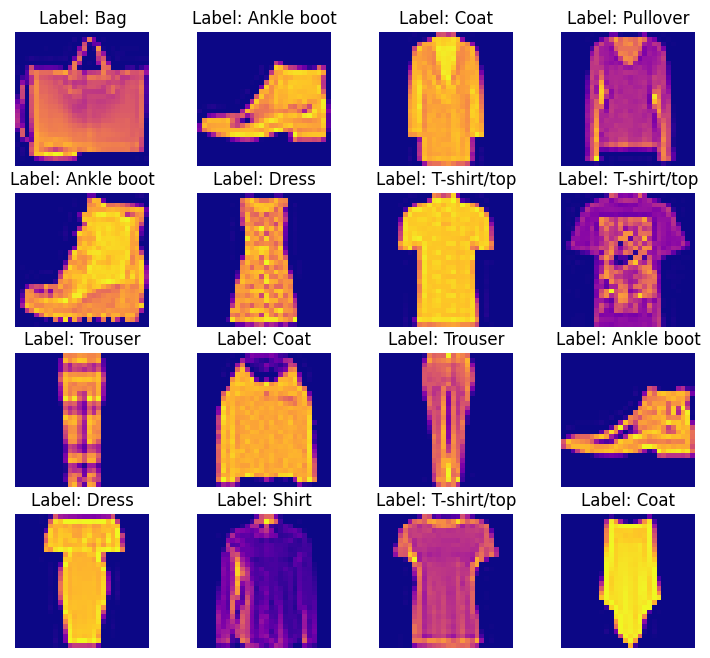

In [ ]:
visualize_data(train_data_loader)

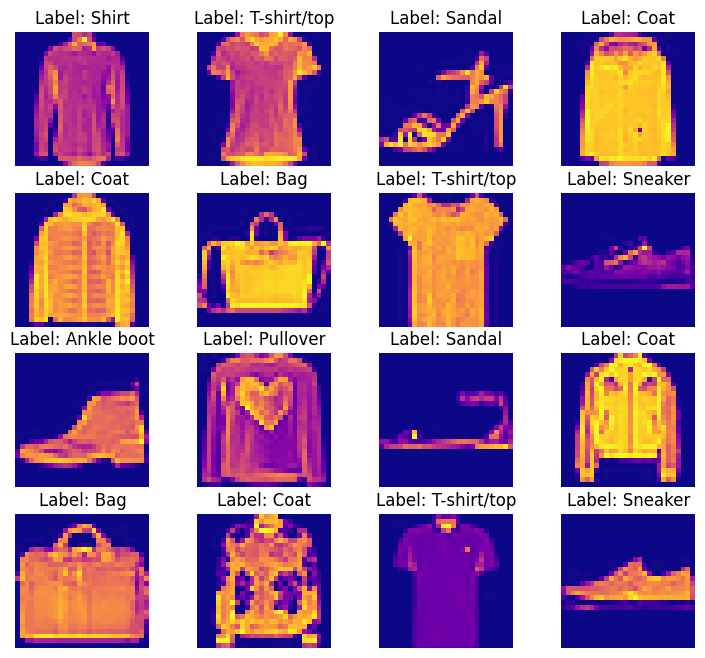

In [ ]:
visualize_data(val_data_loader)

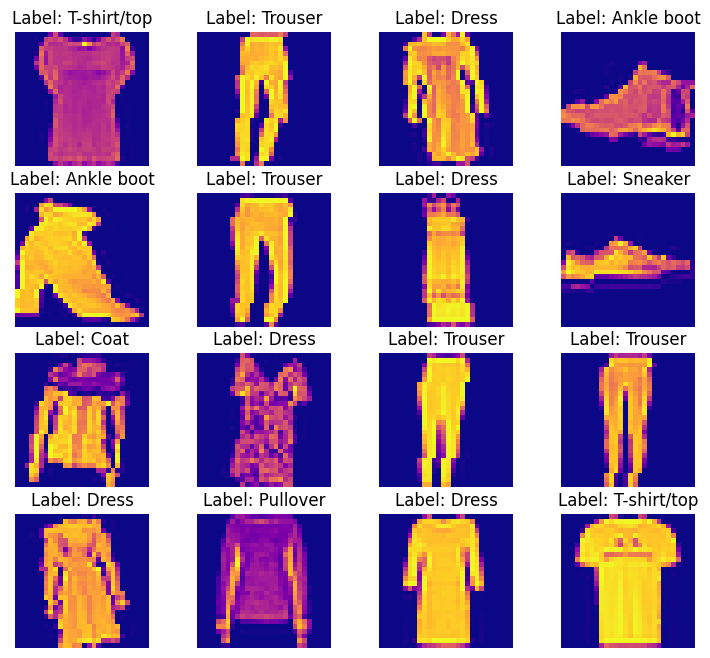

In [ ]:
visualize_data(augmented_train_data_loader)

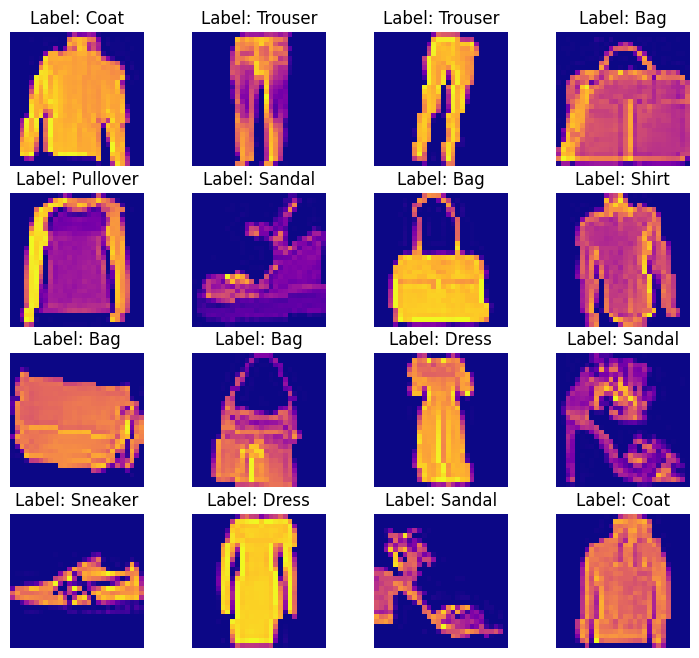

In [ ]:
visualize_data(val_augmented_data_loader)

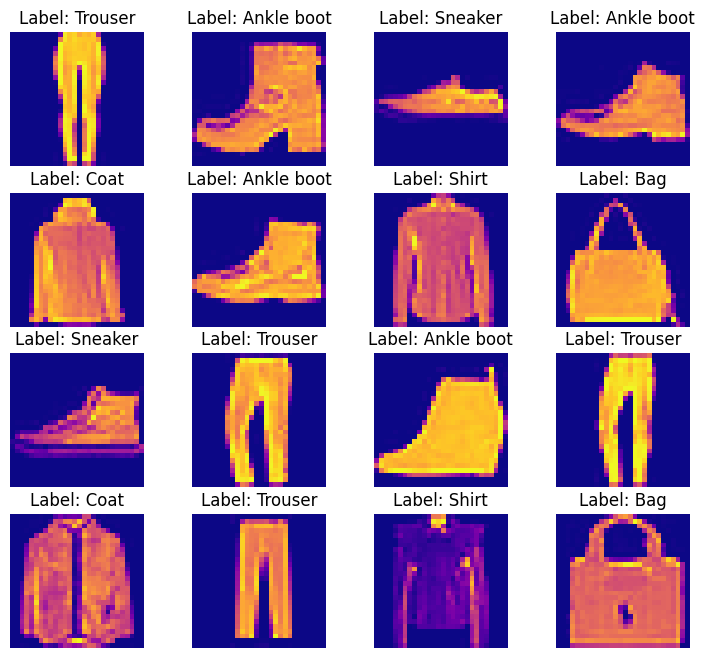

In [ ]:
visualize_data(test_data_loader)

Tamaño del conjunto de datos de entrenamiento: 84000
Tamaño del conjunto de datos de validación: 36000


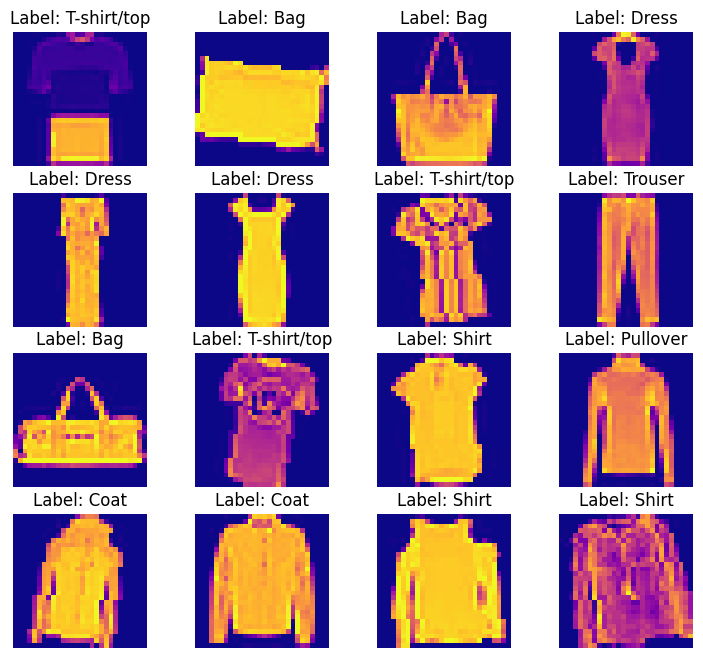

In [ ]:
# Original data
train_data  = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
augmented_train = datasets.FashionMNIST(root='./data', train=True, download=True, transform=augmentations)

# Final data
train_data_full = ConcatDataset([train_data, augmented_train])

train_size_full = int(0.7 * len(train_data_full))
val_size_full = len(train_data_full) - train_size_full
train_data_full, val_data_full = random_split(train_data_full, (train_size_full, val_size_full))

print(f"Tamaño del conjunto de datos de entrenamiento: {len(train_data_full)}")
print(f"Tamaño del conjunto de datos de validación: {len(val_data_full)}")

train_data_loader_full = DataLoader(train_data_full, batch_size=32, shuffle=True)
val_data_loader_full = DataLoader(val_data_full, batch_size=32, shuffle=True)

visualize_data(train_data_loader_full)

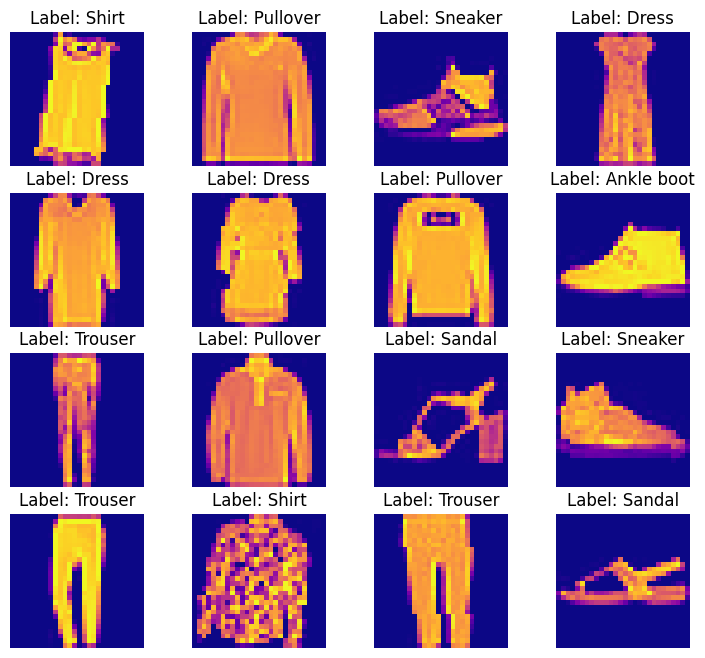

In [ ]:
visualize_data(val_data_loader_full)

In [ ]:
for dataset in [train_data_loader, val_data_loader, augmented_train_data_loader, val_augmented_data_loader, test_data_loader,
                train_data_loader_full, val_data_loader_full]:
  a = next(iter(dataset))
  print(a[0].size())

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])


# **Funciones de Entrenamiento, Validación, Prueba y Accuracy**

In [ ]:
def accuracy(y_true, y_pred):
  '''Función que calcula el accuracy
  Input:
  - y_true: Tensor de etiquetas reales
  - y_pred: Tensor con las predicciones del modelo
  '''
  correct = torch.eq(y_true,y_pred).sum().item()
  acc = (correct/len(y_pred))
  return acc

In [ ]:
def train(dataloader: DataLoader, model: nn.Module, loss_fn, optimizer):
  # Cambiar el modelo a entrenamiento
  model.train()
  train_loss = 0
  train_acc = 0
  # Recorrer cada batch del conjunto de entrenamiento
  for batch_idx, (data, target) in enumerate(dataloader):
    # Cambiar datos a GPU
    data = data.to(device)
    target = target.to(device)
    # 1. Pasar los datos por la red (feedforward)
    y_pred_logs = model(data)
    # 2. Calcular la función de costo
    loss = loss_fn(y_pred_logs, target)
    train_loss += loss
    y_pred = torch.softmax(y_pred_logs, dim=1).argmax(dim=1)
    train_acc += accuracy(target, y_pred)
    # 3. Zero gradient buffers
    optimizer.zero_grad()
    # 4. Backpropagate
    loss.backward()
    # 5. Update weights
    optimizer.step()

  train_loss /= len(dataloader)
  train_acc /= len(dataloader)
  print(f"Train loss: {train_loss:.4f} | Train acc: {train_acc*100.:.4f}%")
  return train_loss, train_acc

In [ ]:
def validate(dataloader: DataLoader, model: nn.Module, loss_fn):
    # Cambiar el modelo a evaluación
    model.eval()
    test_loss = 0
    test_acc = 0
    with torch.inference_mode():
        for data, target in dataloader:
            data = data.to(device)
            target = target.to(device)
            test_pred_logs = model(data)
            val_loss = loss_fn(test_pred_logs, target)
            test_loss += val_loss
            test_pred = torch.softmax(test_pred_logs, dim=1).argmax(dim=1)
            test_acc += accuracy(target, test_pred)

        test_loss /= len(dataloader)
        test_acc /= len(dataloader)

    print(f"Validation loss: {test_loss:.4f} | Validation acc: {test_acc*100.:.4f}%")
    return test_loss, test_acc

In [ ]:
def test_model(dataloader: DataLoader, model: nn.Module, loss_fn):
    # Cambiar el modelo a evaluación
    model.eval()
    test_loss = 0
    test_acc = 0

    y_preds, y_true = [], []
    with torch.inference_mode():
        for data, target in tqdm(dataloader, desc="Making predictions ..."):
            data = data.to(device)
            target = target.to(device)

            test_pred_logs = model(data)
            loss = loss_fn(test_pred_logs, target)
            test_loss += loss
            test_pred = torch.softmax(test_pred_logs, dim=1).argmax(dim=1)
            test_acc += accuracy(target, test_pred)
            y_preds += [test_pred.cpu()]
            y_true += [target.cpu()]

        test_loss /= len(dataloader)
        test_acc /= len(dataloader)

    print(f"Test loss: {test_loss:.4f} | Test acc: {test_acc*100.:.4f}%")
    return test_loss, test_acc, torch.cat(y_preds), torch.cat(y_true)

# **Red 1**

In [ ]:
class FashionCNN1(nn.Module):
  def __init__(self):
    super(FashionCNN1, self).__init__()

    '''
    Capas Convolucionales y de Pooling
    - Todas las capas convolucionales cuentan con un kernel 3x3, así como un MaxPooling (2x2) con desplazamiento (stride) de 2.
    - Todas las capas cuentan con una normalización de batches para estabilizar y acelerar el aprendizaje,
      así como una regularización que desactiva aleatoriamente el 20% (25% en la última capa) de las unidades para prevenir un sobreajuste.
    - La primera capa convolucional tiene 32 filtros y padding de 1.
    - La segunda capa convolucional tiene 64 filtros.
    - La tercera capa convolucional tiene 128 filtros.
    - Todas las capas tienen una función de activación no lineal ReLU que sucede a los filtros.
    '''

    self.layer1 = nn.Sequential(
        nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 3, padding = 1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2, stride = 2),
        nn.Dropout(0.2)
    )

    self.layer2 = nn.Sequential(
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Dropout(0.2)
    )

    self.layer3 = nn.Sequential(
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Dropout(0.25)
    )

    '''
    Capas Completamente Conectadas.
    - Antes de llegar a la primera capa completamente conectada, se convierte la salida tridimensional 128x2x2 de la 3ra capa de convolución
      a un vector de 512, lista para las capas densas.
    - La primera capa completamente conectada pasa los 512 valores de entrada a 600 que pasan por una regularización que apaga el 20% de las neuronas.
      Finalmente pasa por una función de activación no lineal ReLU, dada su simplicidad que concuerda con la sencillez del problema de clasificación
      para la base de datos FashionMNIST, además de que es rápida para las primeras capas.
    - La segunda capa completamente conectada pasa de 600 valores de entrada de la capa anterior a 120, con una regularización idéntica a la de la capa
      anterior. A diferencia de la capa anterior, cuenta con función de activación LeakyReLU, para evitar problemas de unidades muertas dadas
      las transformaciones aplicada hasta este punto (que puede traer consigo valores negativos que impiden el aprendizaje).
    - La tercera capa completamente conectada pasa los 120 valores de entrada de la capa anterior a 10, que concuerda con la cantidad de clases
      de nuestra base de datos.
    '''

    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(in_features = 512, out_features = 600)
    self.drop1 = nn.Dropout(0.2)
    self.relu = nn.ReLU()
    self.drop2 = nn.Dropout(0.2)
    self.fc2 = nn.Linear(in_features = 600, out_features = 120)
    self.leaky_relu = nn.LeakyReLU()
    self.fc3 = nn.Linear(in_features = 120, out_features = 10)

  '''
  El forward propagation observado aquí describe el paso de los datos a través de la red.
  '''

  def forward(self, x):
    '''
    Bloque de convoluciones y poolings.
    '''
    out = self.layer1(x)
    out = self.layer2(out)
    out = self.layer3(out)
    out = out.view(out.size(0), -1)
    '''
    Aplanamiento de la salida de la 3ra capa convolucional.
    '''
    out = self.flatten(out)
    '''
    Primera capa completamente conectada.
    '''
    out = self.fc1(out)
    out = self.drop1(out)
    out = self.relu(out)
    '''
    Segunda capa completamente conectada.
    '''
    out = self.drop2(out)
    out = self.fc2(out)
    out = self.leaky_relu(out)
    '''
    Capa de salida.
    '''
    out = self.fc3(out)

    return out

**Datos Originales**

In [ ]:
model1 = FashionCNN1()
model1.to(device)

error = nn.CrossEntropyLoss()

learning_rate = 0.001
optimizer = torch.optim.AdamW(model1.parameters(), lr = learning_rate)
print(model1)

FashionCNN1(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.2, inplace=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.2, inplace=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.25, inplace=False)
  )
  (flatten): Flatten(sta

In [ ]:
'''
Entrenamiento del primer modelo. Este modelo será el encargado de ser entrenado y validado con la base de datos original,
sin ninguna tipo de aumento de datos o transformación adicional a la normalización y la conversión a tensor.
Será posteriormente comparado con un modelo idéntico pero entrenado y validado con los datos aumentados.
'''
EPOCHS = 10

loss_train, acc_train = [], []
loss_test, acc_test = [], []

for epoch in tqdm(range(EPOCHS)):
  print(f"Epoch: {epoch}\n--------" )
  train_loss, train_acc = train(train_data_loader, model1, error, optimizer)
  test_loss, test_acc = validate(val_data_loader, model1, error)
  loss_train += [train_loss.item()]
  loss_test += [test_loss.item()]
  acc_train += [train_acc]
  acc_test += [test_acc]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
--------
Train loss: 0.5554 | Train acc: 79.4531%
Validation loss: 0.3530 | Validation acc: 87.0282%
Epoch: 1
--------
Train loss: 0.3867 | Train acc: 85.6436%
Validation loss: 0.3213 | Validation acc: 87.7276%
Epoch: 2
--------
Train loss: 0.3422 | Train acc: 87.3762%
Validation loss: 0.2855 | Validation acc: 89.4538%
Epoch: 3
--------
Train loss: 0.3164 | Train acc: 88.3997%
Validation loss: 0.2736 | Validation acc: 89.7924%
Epoch: 4
--------
Train loss: 0.3020 | Train acc: 89.0661%
Validation loss: 0.2505 | Validation acc: 90.7749%
Epoch: 5
--------
Train loss: 0.2857 | Train acc: 89.5873%
Validation loss: 0.2599 | Validation acc: 90.6639%
Epoch: 6
--------
Train loss: 0.2708 | Train acc: 90.1895%
Validation loss: 0.2387 | Validation acc: 91.4465%
Epoch: 7
--------
Train loss: 0.2638 | Train acc: 90.3299%
Validation loss: 0.2462 | Validation acc: 91.0802%
Epoch: 8
--------
Train loss: 0.2519 | Train acc: 90.6964%
Validation loss: 0.2385 | Validation acc: 91.1468%
Epoch: 9
-

In [ ]:
import plotly.express as px

# DataFrames para obtener los valores de costo y acc del entrenamiento y validación
df_loss = pd.DataFrame({'Epoch': range(EPOCHS), 'Train Loss': loss_train, 'Validation Loss': loss_test})
df_acc = pd.DataFrame({'Epoch': range(EPOCHS), 'Train Accuracy': acc_train, 'Validation Accuracy': acc_test})

# Gráfica de costo
fig_loss = px.line(df_loss, x='Epoch', y=['Train Loss', 'Validation Loss'], title='<b>Costo / Epoch</b>', template='plotly_dark',
                   color_discrete_sequence=['blue', 'white'], labels={'value':'Costo', 'variable':'Conjunto de Datos'})
fig_loss.update_layout(title_x=0.5)
fig_loss.show()

# Gráfica de accuracy
fig_acc = px.line(df_acc, x='Epoch', y=['Train Accuracy', 'Validation Accuracy'], title='<b>Accuracy / Epoch</b>', template='plotly_dark',
                  color_discrete_sequence=['blue', 'white'], labels={'value':'Accuracy', 'variable':'Conjunto de Datos'})
fig_acc.update_layout(title_x=0.5)
fig_acc.show()

**Datos Aumentados**

In [ ]:
model2 = FashionCNN1()
model2.to(device)

error = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(model2.parameters(), lr = learning_rate)
print(model2)

FashionCNN1(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.2, inplace=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.2, inplace=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.25, inplace=False)
  )
  (flatten): Flatten(sta

In [ ]:
'''
Entrenamiento del 2do modelo. Este modelo será el encargado de ser entrenado y validado con la base de datos aumentados.
Sus resultados se compararán con el modelo anterior. Posteriormente, serán comparados con otra red con distinta arquitectura.
El mejor modelo será evaluado con el conjunto de datos de prueba (sin los datos aumentados).
'''
loss_train, acc_train = [], []
loss_test, acc_test = [], []

for epoch in tqdm(range(EPOCHS)):
  print(f"Epoch: {epoch}\n--------" )
  train_loss, train_acc = train(augmented_train_data_loader, model2, error, optimizer)
  test_loss, test_acc = validate(val_augmented_data_loader, model2, error)
  loss_train += [train_loss.item()]
  loss_test += [test_loss.item()]
  acc_train += [train_acc]
  acc_test += [test_acc]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
--------
Train loss: 0.6342 | Train acc: 76.4280%
Validation loss: 0.4458 | Validation acc: 83.3703%
Epoch: 1
--------
Train loss: 0.4531 | Train acc: 83.4254%
Validation loss: 0.3702 | Validation acc: 86.6508%
Epoch: 2
--------
Train loss: 0.4112 | Train acc: 85.1247%
Validation loss: 0.3762 | Validation acc: 85.5129%
Epoch: 3
--------
Train loss: 0.3814 | Train acc: 86.1743%
Validation loss: 0.3345 | Validation acc: 88.2382%
Epoch: 4
--------
Train loss: 0.3630 | Train acc: 86.9097%
Validation loss: 0.3185 | Validation acc: 88.5047%
Epoch: 5
--------
Train loss: 0.3501 | Train acc: 87.0930%
Validation loss: 0.3047 | Validation acc: 89.1263%
Epoch: 6
--------
Train loss: 0.3385 | Train acc: 87.6380%
Validation loss: 0.3141 | Validation acc: 88.6434%
Epoch: 7
--------
Train loss: 0.3322 | Train acc: 87.7523%
Validation loss: 0.2969 | Validation acc: 89.2151%
Epoch: 8
--------
Train loss: 0.3200 | Train acc: 88.1950%
Validation loss: 0.2855 | Validation acc: 89.5260%
Epoch: 9
-

In [ ]:
# DataFrames para obtener los valores de costo y acc del entrenamiento y validación
df_loss2 = pd.DataFrame({'Epoch': range(EPOCHS), 'Train Loss': loss_train, 'Validation Loss': loss_test})
df_acc2 = pd.DataFrame({'Epoch': range(EPOCHS), 'Train Accuracy': acc_train, 'Validation Accuracy': acc_test})

# Gráfica de costo
fig_loss = px.line(df_loss2, x='Epoch', y=['Train Loss', 'Validation Loss'], title='<b>Costo / Epoch (Datos Aumentados)</b>', template='plotly_dark',
                   color_discrete_sequence=['blue', 'white'], labels={'value':'Costo', 'variable':'Conjunto de Datos'})
fig_loss.update_layout(title_x=0.5)
fig_loss.show()

# Gráfica de accuracy
fig_acc = px.line(df_acc2, x='Epoch', y=['Train Accuracy', 'Validation Accuracy'], title='<b>Accuracy / Epoch (Datos Aumentados)</b>', template='plotly_dark',
                  color_discrete_sequence=['blue', 'white'], labels={'value':'Accuracy', 'variable':'Conjunto de Datos'})
fig_acc.update_layout(title_x=0.5)
fig_acc.show()

**Datos Mezclados (Aumentados + Originales)**

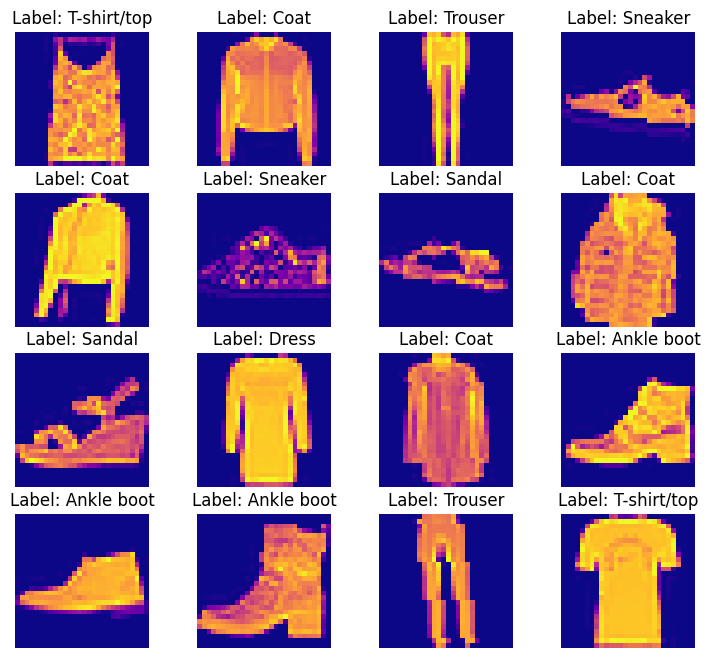

In [ ]:
visualize_data(val_data_loader_full)

In [ ]:
model3 = FashionCNN1()
model3.to(device)

error = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(model3.parameters(), lr = learning_rate)
print(model3)

FashionCNN1(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.2, inplace=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.2, inplace=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.25, inplace=False)
  )
  (flatten): Flatten(sta

In [ ]:
'''
Entrenamiento del 3er modelo. Este modelo será el encargado de ser entrenado y validado con la base de datos aumentados y originales.
Sus resultados se compararán con los modelos anteriores, dada la disminución en el accuracy en el modelo entrenado y validado con datos aumentados.
Posteriormente, serán comparados con otra red con distinta arquitectura.
El mejor modelo será evaluado con el conjunto de datos de prueba (sin los datos aumentados).
'''
loss_train, acc_train = [], []
loss_test, acc_test = [], []

for epoch in tqdm(range(EPOCHS)):
  print(f"Epoch: {epoch}\n--------" )
  train_loss, train_acc = train(train_data_loader_full, model3, error, optimizer)
  test_loss, test_acc = validate(val_data_loader_full, model3, error)
  loss_train += [train_loss.item()]
  loss_test += [test_loss.item()]
  acc_train += [train_acc]
  acc_test += [test_acc]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
--------
Train loss: 0.5166 | Train acc: 80.9702%
Validation loss: 0.3400 | Validation acc: 87.3778%
Epoch: 1
--------
Train loss: 0.3792 | Train acc: 86.1726%
Validation loss: 0.3022 | Validation acc: 88.9111%
Epoch: 2
--------
Train loss: 0.3409 | Train acc: 87.6000%
Validation loss: 0.2706 | Validation acc: 90.0667%
Epoch: 3
--------
Train loss: 0.3195 | Train acc: 88.3452%
Validation loss: 0.2555 | Validation acc: 90.4889%
Epoch: 4
--------
Train loss: 0.3005 | Train acc: 89.0893%
Validation loss: 0.2414 | Validation acc: 91.1361%
Epoch: 5
--------
Train loss: 0.2869 | Train acc: 89.4488%
Validation loss: 0.2657 | Validation acc: 89.8500%
Epoch: 6
--------
Train loss: 0.2778 | Train acc: 89.8952%
Validation loss: 0.2237 | Validation acc: 91.8472%
Epoch: 7
--------
Train loss: 0.2684 | Train acc: 90.1417%
Validation loss: 0.2187 | Validation acc: 91.6778%
Epoch: 8
--------
Train loss: 0.2653 | Train acc: 90.2250%
Validation loss: 0.2144 | Validation acc: 92.1056%
Epoch: 9
-

In [ ]:
# DataFrames para obtener los valores de costo y acc del entrenamiento y validación
df_loss3 = pd.DataFrame({'Epoch': range(EPOCHS), 'Train Loss': loss_train, 'Validation Loss': loss_test})
df_acc3 = pd.DataFrame({'Epoch': range(EPOCHS), 'Train Accuracy': acc_train, 'Validation Accuracy': acc_test})

# Gráfica de costo
fig_loss = px.line(df_loss3, x='Epoch', y=['Train Loss', 'Validation Loss'], title='<b>Costo / Epoch (Datos Mezclados)</b>', template='plotly_dark',
                   color_discrete_sequence=['blue', 'white'], labels={'value':'Costo', 'variable':'Conjunto de Datos'})
fig_loss.update_layout(title_x=0.5)
fig_loss.show()

# Gráfica de accuracy
fig_acc = px.line(df_acc3, x='Epoch', y=['Train Accuracy', 'Validation Accuracy'], title='<b>Accuracy / Epoch (Datos Mezclados)</b>', template='plotly_dark',
                  color_discrete_sequence=['blue', 'white'], labels={'value':'Accuracy', 'variable':'Conjunto de Datos'})
fig_acc.update_layout(title_x=0.5)
fig_acc.show()

Los resultados muestran que las bases de datos y las arquitecturas impactan significativamente en el rendimiento. El modelo entrenado con datos originales (modelo 1) alcanzó una alta precisión rápidamente, mostrando estabilidad y un menor riesgo de sobreajuste, pero podría no generalizar bien a datos nuevos o con variaciones. El modelo con augmentations (modelo 2) tuvo un inicio más lento en precisión, pero mostró mejor capacidad de generalización, debido a la mayor diversidad de datos introducida por las transformaciones. Sin embargo, su  desempeño en validación fue ligeramente inferior en comparación con los datos originales, sugiriendo que las augmentations añadieron ruido o complejidad innecesaria en algunos casos. Finalmente, el modelo entrenado con la combinación de bases (original y augmentations, modelo 3) logró un equilibrio óptimo entre precisión y generalización, alcanzando la mejor validación final. Esto confirma que mezclar datos originales con augmentations es una estrategia efectiva para enriquecer los datos sin comprometer la calidad del aprendizaje del modelo.

# **Red 2**

In [ ]:
class FashionCNN2(nn.Module):
  def __init__(self):
    super(FashionCNN2, self).__init__()

    '''
    Capas Convolucionales y de Pooling de la Red 2
    - Todas las capas convolucionales cuentan con un kernel 3x3, así como un AvgPooling (2x2) con desplazamiento (stride) de 2.
    - Todas las capas cuentan con una normalización de batches para estabilizar y acelerar el aprendizaje,
      así como una regularización que desactiva aleatoriamente el 20% (25% en la última capa) de las unidades para prevenir un sobreajuste.
    - La primera capa convolucional tiene 32 filtros y padding de 1.
    - La segunda capa convolucional tiene 64 filtros.
    - La tercera capa convolucional tiene 128 filtros.
    - Todas las capas tienen una función de activación no lineal ReLU que sucede a los filtros.
    '''

    self.layer1 = nn.Sequential(
        nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 3, padding = 1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.AvgPool2d(kernel_size = 2, stride = 2),
        nn.Dropout(0.2)
    )

    self.layer2 = nn.Sequential(
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.AvgPool2d(2),
        nn.Dropout(0.2)
    )

    self.layer3 = nn.Sequential(
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.AvgPool2d(2),
        nn.Dropout(0.25)
    )

    '''
    Capas Completamente Conectadas.
    - Antes de llegar a la primera capa completamente conectada, se convierte la salida tridimensional 128x2x2 de la 3ra capa de convolución
      a un vector de 512, lista para las capas densas.
    - La primera capa completamente conectada pasa los 512 valores de entrada a 600 que pasan por una regularización que apaga el 20% de las neuronas.
      Finalmente pasa por una función de activación no lineal ReLU, dada su simplicidad que concuerda con la sencillez del problema de clasificación
      para la base de datos FashionMNIST, además de que es rápida para las primeras capas.
    - La segunda capa completamente conectada pasa de 600 valores de entrada de la capa anterior a 120, con una regularización idéntica a la de la capa
      anterior. A diferencia de la red anterior, cuenta con función de activación ReLU al igual que la capa que la precede, debido a la misma razón
      descrita en relación con la sencillez del problema.
    - La tercera capa completamente conectada pasa los 120 valores de entrada de la capa anterior a 10, que concuerda con la cantidad de clases
      de nuestra base de datos.
    '''

    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(in_features = 512, out_features = 600)
    self.drop1 = nn.Dropout(0.2)
    self.relu1 = nn.ReLU()
    self.fc2 = nn.Linear(in_features = 600, out_features = 120)
    self.relu2 = nn.ReLU()
    self.fc3 = nn.Linear(in_features = 120, out_features = 10)

  '''
  El forward propagation observado aquí describe el paso de los datos a través de la red.
  '''
  def forward(self, x):
    '''
    Bloque de convoluciones y poolings.
    '''
    out = self.layer1(x)
    out = self.layer2(out)
    out = self.layer3(out)
    out = out.view(out.size(0), -1)
    '''
    Aplanamiento de la salida de la 3ra capa convolucional.
    '''
    out = self.flatten(out)
    '''
    Primera capa completamente conectada.
    '''
    out = self.fc1(out)
    out = self.drop1(out)
    out = self.relu1(out)
    '''
    Segunda capa completamente conectada.
    '''
    out = self.fc2(out)
    out = self.relu2(out)
    '''
    Capa de salida.
    '''
    out = self.fc3(out)

    return out

**Datos Originales**

In [ ]:
model4 = FashionCNN2()
model4.to(device)

error = nn.CrossEntropyLoss()

learning_rate = 0.001
optimizer = torch.optim.AdamW(model4.parameters(), lr = learning_rate)
print(model4)

FashionCNN2(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (4): Dropout(p=0.2, inplace=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (4): Dropout(p=0.2, inplace=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (4): Dropout(p=0.25, inplace=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=512, out_features=600, bias=True)
  (

In [ ]:
'''
Entrenamiento del primer modelo con AvgPooling y funciones de activación ReLU.
Este modelo será el encargado de ser entrenado y validado con la base de datos original,
sin ninguna tipo de aumento de datos o transformación adicional a la normalización y la conversión a tensor.
Será posteriormente comparado con un modelo idéntico pero entrenado y validado con los datos aumentados.
'''
EPOCHS = 10

loss_train, acc_train = [], []
loss_test, acc_test = [], []

for epoch in tqdm(range(EPOCHS)):
  print(f"Epoch: {epoch}\n--------" )
  train_loss, train_acc = train(train_data_loader, model4, error, optimizer)
  test_loss, test_acc = validate(val_data_loader, model4, error)
  loss_train += [train_loss.item()]
  loss_test += [test_loss.item()]
  acc_train += [train_acc]
  acc_test += [test_acc]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
--------
Train loss: 0.5424 | Train acc: 79.7720%
Validation loss: 0.3694 | Validation acc: 86.3510%
Epoch: 1
--------
Train loss: 0.3699 | Train acc: 86.4004%
Validation loss: 0.3768 | Validation acc: 86.0013%
Epoch: 2
--------
Train loss: 0.3260 | Train acc: 87.8808%
Validation loss: 0.2935 | Validation acc: 88.7711%
Epoch: 3
--------
Train loss: 0.3009 | Train acc: 88.9613%
Validation loss: 0.2827 | Validation acc: 89.8757%
Epoch: 4
--------
Train loss: 0.2877 | Train acc: 89.4017%
Validation loss: 0.2499 | Validation acc: 90.9525%
Epoch: 5
--------
Train loss: 0.2720 | Train acc: 90.0990%
Validation loss: 0.2465 | Validation acc: 91.3577%
Epoch: 6
--------
Train loss: 0.2639 | Train acc: 90.3513%
Validation loss: 0.2456 | Validation acc: 91.0468%
Epoch: 7
--------
Train loss: 0.2511 | Train acc: 90.7297%
Validation loss: 0.2253 | Validation acc: 91.8850%
Epoch: 8
--------
Train loss: 0.2428 | Train acc: 90.9725%
Validation loss: 0.2529 | Validation acc: 90.9136%
Epoch: 9
-

In [ ]:
# DataFrames para obtener los valores de costo y acc del entrenamiento y validación
df_loss4 = pd.DataFrame({'Epoch': range(EPOCHS), 'Train Loss': loss_train, 'Validation Loss': loss_test})
df_acc4 = pd.DataFrame({'Epoch': range(EPOCHS), 'Train Accuracy': acc_train, 'Validation Accuracy': acc_test})

# Gráfica de costo
fig_loss = px.line(df_loss4, x='Epoch', y=['Train Loss', 'Validation Loss'], title='<b>Costo / Epoch</b>', template='plotly_dark',
                   color_discrete_sequence=['blue', 'white'], labels={'value':'Costo', 'variable':'Conjunto de Datos'})
fig_loss.update_layout(title_x=0.5)
fig_loss.show()

# Gráfica de accuracy
fig_acc = px.line(df_acc4, x='Epoch', y=['Train Accuracy', 'Validation Accuracy'], title='<b>Accuracy / Epoch</b>', template='plotly_dark',
                  color_discrete_sequence=['blue', 'white'], labels={'value':'Accuracy', 'variable':'Conjunto de Datos'})
fig_acc.update_layout(title_x=0.5)
fig_acc.show()

**Datos Aumentados**

In [ ]:
model5 = FashionCNN2()
model5.to(device)

error = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(model5.parameters(), lr = learning_rate)
print(model5)

FashionCNN2(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (4): Dropout(p=0.2, inplace=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (4): Dropout(p=0.2, inplace=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (4): Dropout(p=0.25, inplace=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=512, out_features=600, bias=True)
  (

In [ ]:
'''
Entrenamiento del 5to modelo. Este modelo será el encargado de entrenar y validar a la segunda arquitectura con la base de datos aumentados.
Sus resultados se compararán con los modelos anteriores.
'''
loss_train, acc_train = [], []
loss_test, acc_test = [], []

for epoch in tqdm(range(EPOCHS)):
  print(f"Epoch: {epoch}\n--------" )
  train_loss, train_acc = train(augmented_train_data_loader, model5, error, optimizer)
  test_loss, test_acc = validate(val_augmented_data_loader, model5, error)
  loss_train += [train_loss.item()]
  loss_test += [test_loss.item()]
  acc_train += [train_acc]
  acc_test += [test_acc]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
--------
Train loss: 0.6069 | Train acc: 77.2230%
Validation loss: 0.4262 | Validation acc: 84.4583%
Epoch: 1
--------
Train loss: 0.4359 | Train acc: 83.8657%
Validation loss: 0.4191 | Validation acc: 84.5693%
Epoch: 2
--------
Train loss: 0.3945 | Train acc: 85.4032%
Validation loss: 0.3305 | Validation acc: 87.8719%
Epoch: 3
--------
Train loss: 0.3658 | Train acc: 86.4766%
Validation loss: 0.3007 | Validation acc: 88.7600%
Epoch: 4
--------
Train loss: 0.3462 | Train acc: 87.2763%
Validation loss: 0.3086 | Validation acc: 88.3937%
Epoch: 5
--------
Train loss: 0.3335 | Train acc: 87.9236%
Validation loss: 0.2865 | Validation acc: 89.4261%
Epoch: 6
--------
Train loss: 0.3194 | Train acc: 88.1426%
Validation loss: 0.2963 | Validation acc: 88.9876%
Epoch: 7
--------
Train loss: 0.3124 | Train acc: 88.3663%
Validation loss: 0.2783 | Validation acc: 89.8923%
Epoch: 8
--------
Train loss: 0.3013 | Train acc: 88.9709%
Validation loss: 0.2713 | Validation acc: 90.0533%
Epoch: 9
-

In [ ]:
# DataFrames para obtener los valores de costo y acc del entrenamiento y validación
df_loss5 = pd.DataFrame({'Epoch': range(EPOCHS), 'Train Loss': loss_train, 'Validation Loss': loss_test})
df_acc5 = pd.DataFrame({'Epoch': range(EPOCHS), 'Train Accuracy': acc_train, 'Validation Accuracy': acc_test})

# Gráfica de costo
fig_loss = px.line(df_loss5, x='Epoch', y=['Train Loss', 'Validation Loss'], title='<b>Costo / Epoch (Datos Aumentados)</b>', template='plotly_dark',
                   color_discrete_sequence=['blue', 'white'], labels={'value':'Costo', 'variable':'Conjunto de Datos'})
fig_loss.update_layout(title_x=0.5)
fig_loss.show()

# Gráfica de accuracy
fig_acc = px.line(df_acc5, x='Epoch', y=['Train Accuracy', 'Validation Accuracy'], title='<b>Accuracy / Epoch (Datos Aumentados)</b>', template='plotly_dark',
                  color_discrete_sequence=['blue', 'white'], labels={'value':'Accuracy', 'variable':'Conjunto de Datos'})
fig_acc.update_layout(title_x=0.5)
fig_acc.show()

**Datos Mezclados (Originales + Aumentados)**

In [ ]:
model6 = FashionCNN2()
model6.to(device)

error = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(model6.parameters(), lr = learning_rate)
print(model6)

FashionCNN2(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (4): Dropout(p=0.2, inplace=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (4): Dropout(p=0.2, inplace=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (4): Dropout(p=0.25, inplace=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=512, out_features=600, bias=True)
  (

In [ ]:
'''
Entrenamiento del último modelo. Este modelo será el encargado de entrenar y validar a la 2da arquitectura con la base de datos aumentados y originales.
Sus resultados se compararán con los modelos anteriores, dada la disminución en el accuracy en el modelo entrenado y validado con datos aumentados.
El mejor modelo será evaluado con el conjunto de datos de prueba (sin los datos aumentados).
'''
loss_train, acc_train = [], []
loss_test, acc_test = [], []

for epoch in tqdm(range(EPOCHS)):
  print(f"Epoch: {epoch}\n--------" )
  train_loss, train_acc = train(train_data_loader_full, model6, error, optimizer)
  test_loss, test_acc = validate(val_data_loader_full, model6, error)
  loss_train += [train_loss.item()]
  loss_test += [test_loss.item()]
  acc_train += [train_acc]
  acc_test += [test_acc]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
--------
Train loss: 0.4954 | Train acc: 81.5369%
Validation loss: 0.3380 | Validation acc: 87.4250%
Epoch: 1
--------
Train loss: 0.3623 | Train acc: 86.6274%
Validation loss: 0.2892 | Validation acc: 89.3472%
Epoch: 2
--------
Train loss: 0.3274 | Train acc: 87.9357%
Validation loss: 0.2609 | Validation acc: 90.1028%
Epoch: 3
--------
Train loss: 0.3012 | Train acc: 88.9143%
Validation loss: 0.2509 | Validation acc: 90.6722%
Epoch: 4
--------
Train loss: 0.2848 | Train acc: 89.4976%
Validation loss: 0.2382 | Validation acc: 91.2361%
Epoch: 5
--------
Train loss: 0.2730 | Train acc: 89.9679%
Validation loss: 0.2303 | Validation acc: 91.4444%
Epoch: 6
--------
Train loss: 0.2621 | Train acc: 90.2583%
Validation loss: 0.2194 | Validation acc: 91.7778%
Epoch: 7
--------
Train loss: 0.2544 | Train acc: 90.6167%
Validation loss: 0.2200 | Validation acc: 91.8278%
Epoch: 8
--------
Train loss: 0.2444 | Train acc: 90.9226%
Validation loss: 0.2182 | Validation acc: 91.8917%
Epoch: 9
-

In [ ]:
# DataFrames para obtener los valores de costo y acc del entrenamiento y validación
df_loss6 = pd.DataFrame({'Epoch': range(EPOCHS), 'Train Loss': loss_train, 'Validation Loss': loss_test})
df_acc6 = pd.DataFrame({'Epoch': range(EPOCHS), 'Train Accuracy': acc_train, 'Validation Accuracy': acc_test})

# Gráfica de costo
fig_loss = px.line(df_loss6, x='Epoch', y=['Train Loss', 'Validation Loss'], title='<b>Costo / Epoch (Datos Mezclados)</b>', template='plotly_dark',
                   color_discrete_sequence=['blue', 'white'], labels={'value':'Costo', 'variable':'Conjunto de Datos'})
fig_loss.update_layout(title_x=0.5)
fig_loss.show()

# Gráfica de accuracy
fig_acc = px.line(df_acc6, x='Epoch', y=['Train Accuracy', 'Validation Accuracy'], title='<b>Accuracy / Epoch (Datos Mezclados)</b>', template='plotly_dark',
                  color_discrete_sequence=['blue', 'white'], labels={'value':'Accuracy', 'variable':'Conjunto de Datos'})
fig_acc.update_layout(title_x=0.5)
fig_acc.show()

Los resultados obtenidos en los modelos 4, 5 y 6, que emplean la segunda arquitectura CNN implementada, destacan variaciones significativas según el tipo de datos y el nivel de augmentación aplicado. El modelo 4, entrenado con datos originales, mostró un desempeño consistente con una precisión de validación final del 92.18%, indicando que el modelo generaliza bien en condiciones estándar. En contraste, el modelo 5, entrenado con datos aumentados, evidenció un rendimiento inicial más bajo pero logró estabilizarse cerca del 90.03% de precisión de validación. Esto sugiere que la augmentación introduce mayor diversidad, lo cual puede beneficiar la robustez del modelo, aunque requiera más iteraciones para converger. Finalmente, el modelo 6, entrenado con el conjunto de datos completo, alcanzó la mejor precisión de validación, 92.64%, y mostró la menor pérdida de validación (0.1977), reflejando que la cantidad de datos y su diversidad son cruciales para un mejor aprendizaje del modelo. La arquitectura CNN, complementada con el Average Pooling y otras técnicas como Batch Normalization, Dropout y el uso de funciones de activación ReLU, ha demostrado ser eficiente para la clasificación en FashionMNIST, incluso en escenarios con diferentes configuraciones de datos.

# Transfer Learning

In [ ]:
!pip install torchvision==0.13.0 --quiet

In [ ]:
!pip install torchinfo --quiet

In [ ]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import ConcatDataset, DataLoader, random_split
from torch import nn
from torch import optim
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import random
import plotly.express as px
from torchinfo import summary
from tqdm.auto import tqdm
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
print(device)

cuda


In [ ]:
# Obtener los pesos del modelo preentrenado EfficientNet_B0
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT= mejores pesos disponibles de un modelo preentrenado
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [ ]:
#Tranformamos las imágenes a 224 x 224 pixeles, a una escala de grises de 3 canales y a tensores.
transformations_TL = transforms.Compose([
    transforms.Resize(224),
    transforms.Grayscale(3),  # Convert to 3 channels
    transforms.ToTensor(),
    # Se normaliza con el promedio y desviación estandar del modelo preentrenado
    transforms.Normalize(mean=weights.transforms().mean, std=weights.transforms().std)
])

transformations_TL

Compose(
    Resize(size=224, interpolation=bilinear, max_size=None, antialias=None)
    Grayscale(num_output_channels=3)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

In [ ]:
train_data_TL  = datasets.FashionMNIST(root='data', train=True, download=True, transform=transformations_TL)
test_data_TL = datasets.FashionMNIST(root='data', train=False, download=True, transform=transformations_TL)

In [ ]:
img, _ = train_data_TL[0]
print(f"Tamaño de la imagen: {img.shape}")

Tamaño de la imagen: torch.Size([3, 224, 224])


In [ ]:
train_size_TL = int(0.7 * len(train_data_TL)) # Del conjunto de datos de entrenamiento, se usará solo el 70% para entrenar y el 30% restante para la validación
val_size_TL = len(train_data_TL) - train_size_TL
train_data_TL, val_data_TL = random_split(train_data_TL, (train_size_TL, val_size_TL))

print(f"Tamaño del conjunto de datos de entrenamiento: {len(train_data_TL)}")
print(f"Tamaño del conjunto de datos de validación: {len(val_data_TL)}")
print(f"Tamaño del conjunto de datos de prueba: {len(test_data_TL)}")

Tamaño del conjunto de datos de entrenamiento: 42000
Tamaño del conjunto de datos de validación: 18000
Tamaño del conjunto de datos de prueba: 10000


In [ ]:
BATCH_SIZE = 16
train_dataloader_TL = DataLoader(dataset = train_data_TL,
                               batch_size = BATCH_SIZE,
                               shuffle = True)

In [ ]:
val_dataloader_TL = DataLoader(dataset = val_data_TL,
                               batch_size = BATCH_SIZE,
                               shuffle = False)

In [ ]:
test_dataloader_TL = DataLoader(dataset = test_data_TL,
                               batch_size = BATCH_SIZE,
                               shuffle = False)

In [ ]:
print(f"Número de batches en el train loader: {len(train_dataloader_TL)} batches de {BATCH_SIZE} imágenes cada uno")
print(f"Número de batches en el validation loader: {len(val_dataloader_TL)} batches de {BATCH_SIZE} imágenes cada uno")
print(f"Número de batches en el test loader: {len(test_dataloader_TL)} batches de {BATCH_SIZE} imágenes cada uno")

Número de batches en el train loader: 2625 batches de 16 imágenes cada uno
Número de batches en el validation loader: 1125 batches de 16 imágenes cada uno
Número de batches en el test loader: 625 batches de 16 imágenes cada uno


In [ ]:
# Verificar que hay dentro del DataLoader
train_batches_TL, labels_TL = next(iter(train_dataloader_TL))
print(train_batches_TL.shape)
print(f"Label shape: {labels_TL.shape}")

torch.Size([16, 3, 224, 224])
Label shape: torch.Size([16])


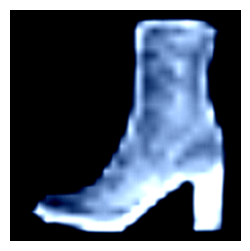

In [ ]:
# Visualizar una imagen aleatoria del batch
random_idx = random.randint(0, len(train_batches_TL)-1)
img_batch = train_batches_TL[random_idx]
fig = plt.figure(figsize=(3,3))
plt.imshow(img_batch.squeeze().permute(1, 2, 0))
plt.axis("off")
plt.show()

In [ ]:
# Importamos el modelo Efficient_B0
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

In [ ]:
# Resumimos el modelo y definimos el input size
summary(model=model,
        input_size=(64, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=16,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape      Output Shape     Param #          Trainable
EfficientNet (EfficientNet)                                  [64, 3, 224, 224] [64, 1000]       --               True
├─Sequential (features)                                      [64, 3, 224, 224] [64, 1280, 7, 7] --               True
│    └─Conv2dNormActivation (0)                              [64, 3, 224, 224] [64, 32, 112, 112] --               True
│    │    └─Conv2d (0)                                       [64, 3, 224, 224] [64, 32, 112, 112] 864              True
│    │    └─BatchNorm2d (1)                                  [64, 32, 112, 112] [64, 32, 112, 112] 64               True
│    │    └─SiLU (2)                                         [64, 32, 112, 112] [64, 32, 112, 112] --               --
│    └─Sequential (1)                                        [64, 32, 112, 112] [64, 16, 112, 112] --               True
│    │    └─MBConv (0)                   

In [ ]:
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [ ]:
# Para congelar los pesos en la sección de características requerimos poner requires_grad=False
for param in model.features.parameters():
    param.requires_grad = False

In [ ]:
# Recrear la sección del calsificador con los datos de nuestro modelo
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2),
    torch.nn.Linear(in_features=1280,
                    out_features=10,
                    bias=True)).to(device)

In [ ]:
# Volver a ver el resumen del modelo
summary(model,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 10]             --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [ ]:
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [ ]:
# Definimos el optimizador
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# Definimos la función de costo
criterion = nn.CrossEntropyLoss()

In [ ]:
def accuracy(y_true, y_pred):
    '''Función que calcula el accuracy
    Input:
    - y_true: Tensor de etiquetas reales
    - y_pred: Tensor con las predicciones del modelo
    '''
    y_pred_classes = torch.argmax(y_pred, dim=1)  # Obtener clases predichas
    correct = torch.eq(y_true, y_pred_classes).sum().item()
    acc = correct / len(y_true)
    return acc

In [ ]:
def train(dataloader: DataLoader, model: nn.Module, loss_fn, optimizer):

    model.train() ##
    train_loss = 0
    train_acc = 0
    # Recorrer cada batch del conjunto de entrenamiento
    for batch_idx, (data, target) in enumerate(dataloader):
        # Cambiar datos a GPU
        data = data.to(device)
        target = target.to(device).to(torch.int64) #Changed to .to(torch.int64)
        # 1. Pasar los datos por la red (feedforward)
        y_pred_logs = model(data)
        # 2. Calcular la función de costo
        # The target tensor should be 1D for CrossEntropyLoss
        #target = target.unsqueeze(1)  # Remove this line - we don't need to add an extra dimension
        loss = loss_fn(y_pred_logs, target)
        train_loss += loss
        # Utilizar la función torch.sigmoid para convertir los logs a un valor entre 0 y 1
        train_acc += accuracy(target, y_pred_logs) # Calcular accuracy
        # 3. Zero gradient buffers
        optimizer.zero_grad()
        # 4. Backpropagate
        loss.backward()
        # 5. Update weights
        optimizer.step()

    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    print(f"Train loss: {train_loss:.5f} | Train acc: {train_acc*100.:.4f}")
    return train_loss, train_acc

In [ ]:
def validate(dataloader: DataLoader, model: nn.Module, loss_fn):
    model.eval()
    val_loss = 0
    val_acc = 0
    with torch.inference_mode():
        for data, target in dataloader:

            data = data.to(device)
            target = target.to(device).to(torch.int64)


            val_pred_logs = model(data)
            val_loss += loss_fn(val_pred_logs, target).item()


            y_pred_classes = torch.argmax(val_pred_logs, dim=1)


            correct = torch.eq(target, y_pred_classes).sum().item()
            val_acc += correct / len(target)

    val_loss /= len(dataloader)
    val_acc /= len(dataloader)

    print(f"Val loss: {val_loss:.4f} | Val acc: {val_acc*100:.2f}%")
    return val_loss, val_acc

In [ ]:
'''
Entrenamiento del séptimo modelo. Este modelo será el encargado de ser entrenado y validado con la base de datos original, siendo transformado a 224x224 pixeles, a una escala de grises y a tensores.
Igual se normalizó utilizando la media y la desviación estándar del modelo preentrenado.
Será posteriormente comparado con un modelo idéntico pero entrenado y validado con los datos aumentados.
'''
EPOCHS = 10

loss_train = []
acc_train = []
loss_val = []
acc_val = []

for epoch in tqdm(range(EPOCHS)):
    print(f"Epoch: {epoch}\n--------" )
    train_loss, train_acc = train(train_dataloader_TL, model, criterion, optimizer)
    val_loss, val_acc = validate(val_dataloader_TL, model, criterion)
    loss_train.append(train_loss)
    loss_val.append(val_loss)
    acc_train.append(train_acc)
    acc_val.append(val_acc)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
--------
Train loss: 0.51800 | Train acc: 81.6405
Val loss: 0.3985 | Val acc: 85.91%
Epoch: 1
--------
Train loss: 0.50192 | Train acc: 82.2167
Val loss: 0.3856 | Val acc: 86.31%
Epoch: 2
--------
Train loss: 0.49195 | Train acc: 82.5976
Val loss: 0.3803 | Val acc: 86.49%
Epoch: 3
--------
Train loss: 0.48509 | Train acc: 82.6143
Val loss: 0.3786 | Val acc: 86.44%
Epoch: 4
--------
Train loss: 0.48597 | Train acc: 82.5643
Val loss: 0.3747 | Val acc: 86.66%
Epoch: 5
--------
Train loss: 0.48121 | Train acc: 82.7048
Val loss: 0.3717 | Val acc: 86.81%
Epoch: 6
--------
Train loss: 0.47597 | Train acc: 83.0524
Val loss: 0.3690 | Val acc: 86.53%
Epoch: 7
--------
Train loss: 0.48077 | Train acc: 82.9833
Val loss: 0.3862 | Val acc: 86.29%
Epoch: 8
--------
Train loss: 0.48042 | Train acc: 82.9762
Val loss: 0.3780 | Val acc: 86.72%
Epoch: 9
--------
Train loss: 0.47271 | Train acc: 83.2048
Val loss: 0.3601 | Val acc: 87.04%


Los resultados obtenidos en el modelo 7, que consiste en aplicar Transfer Learning y esto significa que se utiliza un modelo ya preentrenado. El modelo preentrenado utilizado fue: EfficientNet-B0. La precisión en los datos de entrenamiento fue aumentando gradualemente, llegando a un falor final de 83.2 %. Por otro lado, la presición en los datos de validación, en su última época alcanzó un valor de 87.04 %.

En general, los resultados sugieren que el uso de Transfer Learning ha sido efectivo para capturar patrones relevantes en Fashion-MNIST, alcanzando una precisión sólida pero no siendo el más efectivo a comparación de los otros modelos.

# **Evaluación Real del Modelo**

**Segunda Arquitectura con Datos Mezclados**

In [ ]:
# Realizar la evaluación
test_loss, test_acc, y_preds, y_true = test_model(test_data_loader, model6, error)

Making predictions ...:   0%|          | 0/313 [00:00<?, ?it/s]

Test loss: 0.2152 | Test acc: 92.3123%


              precision    recall  f1-score   support

 T-shirt/top       0.87      0.89      0.88      1000
     Trouser       0.99      0.98      0.99      1000
    Pullover       0.87      0.90      0.89      1000
       Dress       0.92      0.92      0.92      1000
        Coat       0.88      0.90      0.89      1000
      Sandal       0.99      0.97      0.98      1000
       Shirt       0.80      0.74      0.77      1000
     Sneaker       0.95      0.98      0.97      1000
         Bag       0.99      0.98      0.99      1000
  Ankle boot       0.97      0.97      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



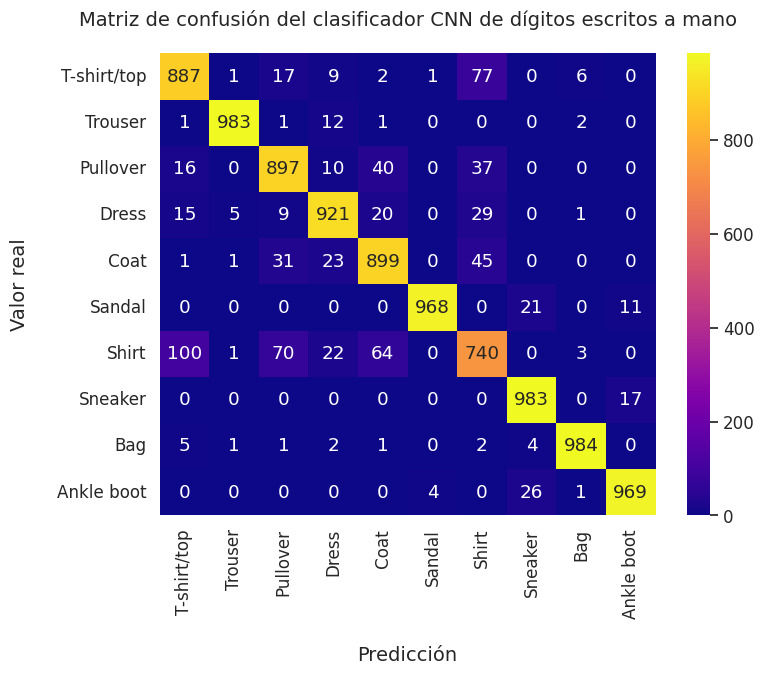

In [ ]:
# Convertir tensores a arreglos numpy
y_true = y_true.numpy()
y_preds = y_preds.numpy()

# Utilizar matriz de confusión
cf_matrix = confusion_matrix(y_true, y_preds)

# Reporte de clasificación
print(classification_report(y_true, y_preds, target_names=dataset_classes.values()))

plt.figure(figsize=(8,6))
# Modificar el tamaño del texto
sns.set(font_scale = 1.1)

# Plot Matriz de confusión con heatmaps
# Parámetros:
# - first param - Matriz de confusión en un formato array
# - annot = True: Muestra los números en cada celda del heatmap
# - fmt = 'd': Muestra los números como enteros.
ax = sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='plasma')

# set plot title
ax.set_title("Matriz de confusión del clasificador CNN de prendas", fontsize=14, pad=20)

# set x-axis label and ticks.
ax.set_xlabel("Predicción", fontsize=14, labelpad=20)
ax.xaxis.set_ticklabels(dataset_classes.values(), rotation=90)

# set y-axis label and ticks
ax.set_ylabel("Valor real", fontsize=14, labelpad=20)
ax.yaxis.set_ticklabels(dataset_classes.values(), rotation=0)

# set plot title
ax.set_title("Matriz de confusión del clasificador CNN de dígitos escritos a mano", fontsize=14, pad=20)
plt.show()

**Conclusión de la prueba**

El modelo 6, evaluado mediante su matriz de confusión y el reporte de clasificación, demostró un desempeño sólido con una **precisión general del 92%** sobre el conjunto de prueba. Las métricas específicas revelaron un excelente rendimiento en categorías como "Trouser", "Sandal" y "Bag", con valores de precisión y recall cercanos al 99%, mientras que la categoría "Shirt" presentó el mayor desafío, alcanzando una precisión del 80% y un recall del 74%, posiblemente debido a similitudes visuales con otras clases. La matriz de confusión muestra que los errores más frecuentes ocurren en confusiones entre "Shirt" y clases como "T-shirt/top" y "Pullover", lo que indica áreas de mejora potencial. En términos generales, el modelo demuestra su capacidad para clasificar correctamente las imágenes de FashionMNIST en la mayoría de los casos, destacándose por su robustez y capacidad de generalización, especialmente con el uso del conjunto de datos completo y técnicas como la normalización por lotes y el dropout. Esto lo convierte en un clasificador confiable y eficiente para aplicaciones prácticas relacionadas con este dominio.

# **Conclusión del mejor modelo**

Después de probar los 7 modelos con los datos de entrenamiento y validación, el mejor rendimiento en términos de precisión y generalización se obtuvo con los modelos que utilizaron la combinación de datos originales y augmentations (modelos 3 y 6), particularmente en la segunda arquitectura (modelo 6), que alcanzó una precisión final de 92.64%. Esto destaca la importancia de enriquecer los datos y utilizar arquitecturas optimizadas con técnicas como Average Pooling, Batch Normalization, y Dropout.

Por otro lado, aunque Transfer Learning (modelo 7) demostró ser efectivo y práctico, no logró superar a los modelos diseñados y entrenados desde cero específicamente para Fashion-MNIST. Esto sugiere que para conjuntos de datos pequeños y específicos, entrenar redes desde cero con datos enriquecidos puede ser más beneficioso que aplicar modelos preentrenados.

# Conclusiones Individuales

## Santiago Jiménez Pasillas

El proyecto me permitió aprender de manera profunda a implementar redes neuronales utilizando PyTorch, lo cual representó un avance significativo, ya que anteriormente trabajaba únicamente con sklearn. Disfruté especialmente experimentar con diferentes estrategias para mejorar el rendimiento de las redes, como el uso de técnicas de data augmentation y la aplicación de transfer learning con modelos preentrenados. Sin embargo, creo que con más tiempo podría haber explorado otros modelos o enfoques para optimizar aún más la precisión de las redes. Además, valoro mucho el trabajo en equipo con mi compañero Guillermo, ya que logramos una excelente colaboración al complementarnos y entendernos perfectamente, lo que contribuyó al éxito del proyecto.

Actividades Realizadas: Por mi parte, realicé el modelo con el transfer learning, al igual que en la carga de datos y por último en la red 2. Analicé los resultados de los modelos.

## Guillermo Barbosa Martínez

En esta situación problema logré comprender las distintas técnicas de pre-procesamiento de grandes cantidades de datos, en especial para el caso de clasificación de imágenes y el procesamiento de estas para modelos de capas profundas. He disfrutado bastante la experiencia de aprender, con un problema mucho más cotidiano y práctico, así como la experimentación con la implementación de estos modelos y la aplicación de técnicas adicionales como el uso de modelos preentrenados, o transfer learning, y el data augmentation, llevándome un poderoso insight como lo es que la complejidad de los modelos y arquitecturas debe ir de la mano con la complejidad de la base de datos y el problema, es decir, lo que se desea lograr. La colaboración y organización en equipo con mi compañero Santiago fueron vitales para llegar a estos hallazgos, puesto que nos permitió descubrir errores, corregirlos junto con otras prácticas que podían comprometer nuestros recursos computacionales. En este caso, contando con menos limitantes en ese sentido, me parece que los modelos elegidos, pese a demostrar una estabilidad en su aprendizaje y mantenerse robustos en su evaluación correspondiente, tienen áreas de oportunidad que no se deben dejar pasar. En este caso, podríamos experimentar introduciendo algunas funciones más complejas para las capas o probar con distintos tamaños de kernel, así como con modelos que hagan uso de ambos poolings para contribuir a la diversidad de los datos que balancea el sumarle ruido a las imágenes con el augmentation o simplemente con modelos más sencillos en sintonía con la base de datos trabajada.

Actividades Realizadas: La red 1, al igual que la carga de datos y la red 2. También realicé el análisis de resultados de los modelos y evaluación del modelo de la red 2 con datos mezclados (modelo 6)